In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import os
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [2]:
# GROWTH RULE
import euler_scheme_1d_with_growth.two_morph as two_morph

In [3]:
from euler_scheme_1d_with_growth.matplotlib_defaults import *

# Load results

In [4]:
folder = r'results_of_numerics/two_morph/dynamics/'

In [5]:
# Read parameters back from the file
file_path = os.path.join(folder, "parameters.txt")

with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()
        if line and not line.endswith(":"):  # Ignore empty lines and section headers
            key, value = line.split(": ")
            if key == "lambda (sqrt(D/beta))":  # Handle special key for lambda
                lam = float(value)
            elif key == "t (array length)":
                continue  # Ignore array length information
            elif "." in value or "e" in value:  # Handle float values
                exec(f"{key} = {float(value)}")
            else:  # Handle integer values
                exec(f"{key} = {int(value)}")

In [6]:
def list_visible_folders(path):
    return [
        item for item in os.listdir(path)
        if not item.startswith(".") and os.path.isdir(os.path.join(path, item))
    ]

In [7]:
thresholds_to_test = np.unique( [ float(nfolder.split('_')[1]) for nfolder in list_visible_folders( folder )] )

In [8]:
g_to_test = np.unique( [ float(nfolder.split('_')[-1]) for nfolder in list_visible_folders( folder )] )

In [9]:
thresholds_to_test

array([0.15   , 0.18375, 0.2175 , 0.25125, 0.285  ])

In [10]:
thresholds_to_test = thresholds_to_test

In [11]:
g_to_test

array([0.5, 1. , 5. ])

In [12]:
# for plotting
Lfinals = np.linspace(0, 4 * L0, 100)

In [13]:
thresholds = np.array( [
    two_morph.threshold_vs_Lfinal(Lfinal, x0, lam, alpha, w, beta, D) 
    for Lfinal in Lfinals] )

In [14]:
print( thresholds_to_test )
Lfinals_to_reach   = np.array([
    two_morph.Lfinal(threshold, x0, lam, alpha, w, beta, D) for threshold in thresholds_to_test
])

[0.15    0.18375 0.2175  0.25125 0.285  ]


In [15]:
Lfinal_simulated = {
    g: dict(zip(thresholds_to_test, np.zeros(len(thresholds_to_test))))
    for g in g_to_test
}

# Check of simulation: Lfinal(time)

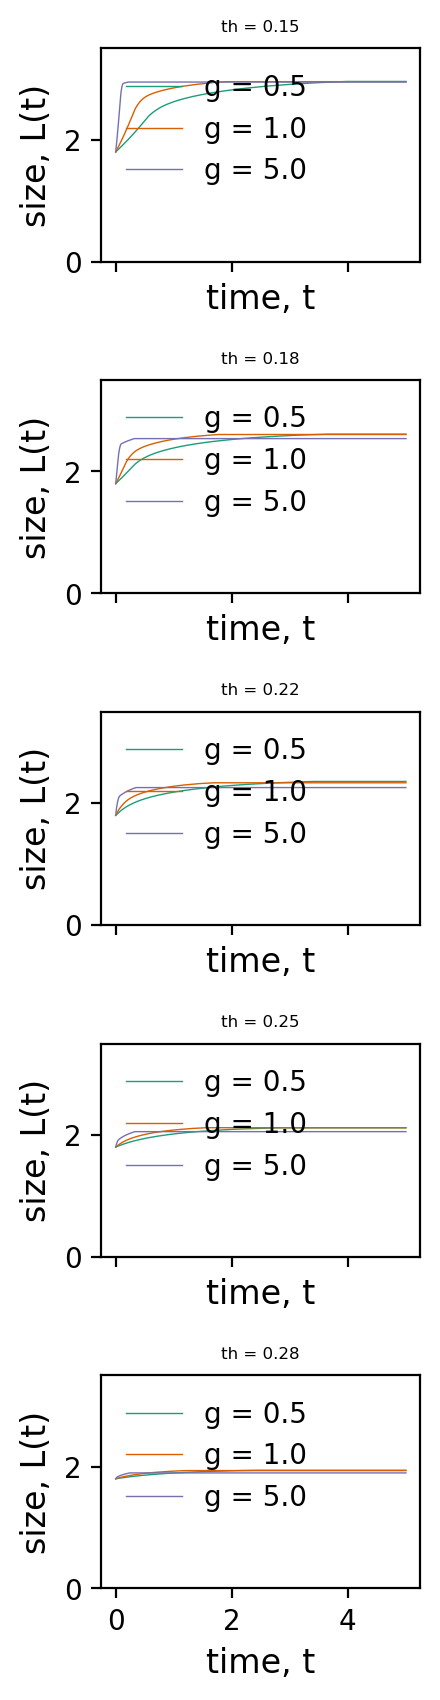

In [16]:
nrows, ncols = len(thresholds_to_test), 1
fig, ax = plt.subplots( nrows, ncols, figsize=(default_figsize["large"][0]/3, default_figsize["large"][1]), dpi=200, sharex=True, sharey=True )

# Iterate through the grid of subplots
for i, ng in enumerate(g_to_test):
    for j, nth in enumerate(thresholds_to_test):
        
        for nfolder in os.listdir( folder ):
            if ( str(ng) in nfolder) and ( str(nth) in nfolder):
                nfolder = os.path.join(folder, nfolder) + '/'
                time_to_save = np.load( nfolder + 'time_to_save.npy')
                Lt           = np.load( nfolder + 'Lt.npy')
                Lfinal_simulated[ng][nth] = Lt[-1]
                
        ax[j].plot( time_to_save, Lt, label = f'g = {ng}' )
        ax[j].set_title(f'th = {np.round(nth, 2)}', fontsize=6)
        ax[j].set_xlabel('time, t')
        ax[j].set_ylabel('size, L(t)')
        ax[j].legend()
        ax[j].set_ylim(0, 3.5)

plt.tight_layout()          
plt.show()

# Lfinal( threshold )

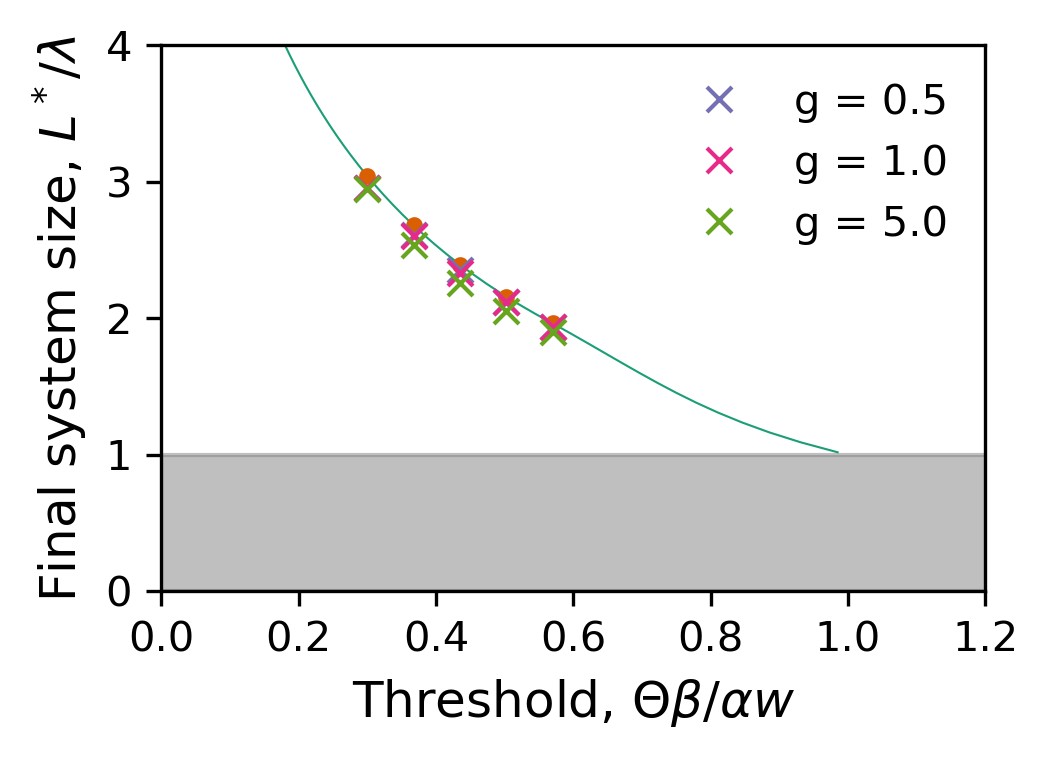

In [17]:
fig = plt.figure(figsize = default_figsize['small'])
ax = plt.subplot()

ax.plot( thresholds*beta/alpha/w, Lfinals/lam )
ax.plot( thresholds_to_test*beta/alpha/w, Lfinals_to_reach/lam, '.' )

for ng in Lfinal_simulated.keys():
    ax.plot( 
        np.array(list(Lfinal_simulated[ng].keys()))*beta/alpha/w, 
        np.array(list([Lfinal_simulated[ng][nth] for nth in Lfinal_simulated[ng].keys()]))/lam, 
        'x',
        markerfacecolor='none',
        label = f'g = {ng}'
    )

#ax.plot( threshold_growth*beta/alpha/w, L0/lam, 'r.', label='Initial size, L0')
#ax.plot( threshold_growth*beta/alpha/w, Lfinal_simulated[g][threshold_growth]/lam, 'b.', label='Final size, L*')

ax.fill_between( np.linspace(0, 2), 0, x0 + w, color='gray', alpha=0.5)
    
ax.set_xlabel(r'Threshold, $\Theta \beta / \alpha w$')
ax.set_ylabel(r'Final system size, $L^*/\lambda$')
plt.xlim( 0, 1.2 )
plt.ylim( 0, 4 )
ax.legend(loc='upper right')

plt.savefig('fig/two_morph_Lfinal_dynamics.pdf', bbox_inches='tight')

plt.show()

# Kymographs

In [18]:
def plot_kymograph( nrows=51 ):
    nrows, ncols = nrows, 1
    fig, ax = plt.subplots(nrows, ncols )
    #, figsize=(default_figsize["small"][0], default_figsize["small"][1]/2), sharex=True, sharey=True, gridspec_kw={'hspace': 0})
    t_to_plot = np.arange(0, 0.6*tmax+small_number, 0.6*tmax/nrows)
    
    middle = 0
    for i in range(1, ncols*nrows+1):
        
        ax = plt.subplot(nrows, ncols, i)
        n = int(t_to_plot[i - 1] / dt / (ndt / ndt_to_save))

        # shift to maintain the growth zone middle at the same position        
        if grsizet[n] != 0:
            x0gr = x_centerst[n][ np.nonzero( grt[n] )[0][0] ]  # Center position of the green rectangle
            x_start = middle - Lt[n]/2
        else:
            x_start = middle - Lt[n]/2
    
        ax.add_patch(plt.Rectangle( (x_start, 0), Lt[n], 1, color='gray', alpha=0.5))
            
        ax.add_patch(plt.Rectangle( (x_start+x0, 0),         w,     1, color='red',  alpha=0.5))
        ax.add_patch(plt.Rectangle( (x_start+Lt[n]-w-x0, 0), w,     1, color='blue', alpha=0.5))
    
        if grsizet[n] != 0:
            x0gr = x_centerst[n][ np.nonzero( grt[n] )[0][0] ]
            ax.add_patch(plt.Rectangle((x_start + x0gr, 0), grsizet[n], 1, color='green', alpha=0.5))
    
        #ax.plot(x_centerst[n], grt[n])
        ax.set_xlim(-0.6*max(Lt), 0.5*max(Lt))
        ax.set_axis_off()

    return fig

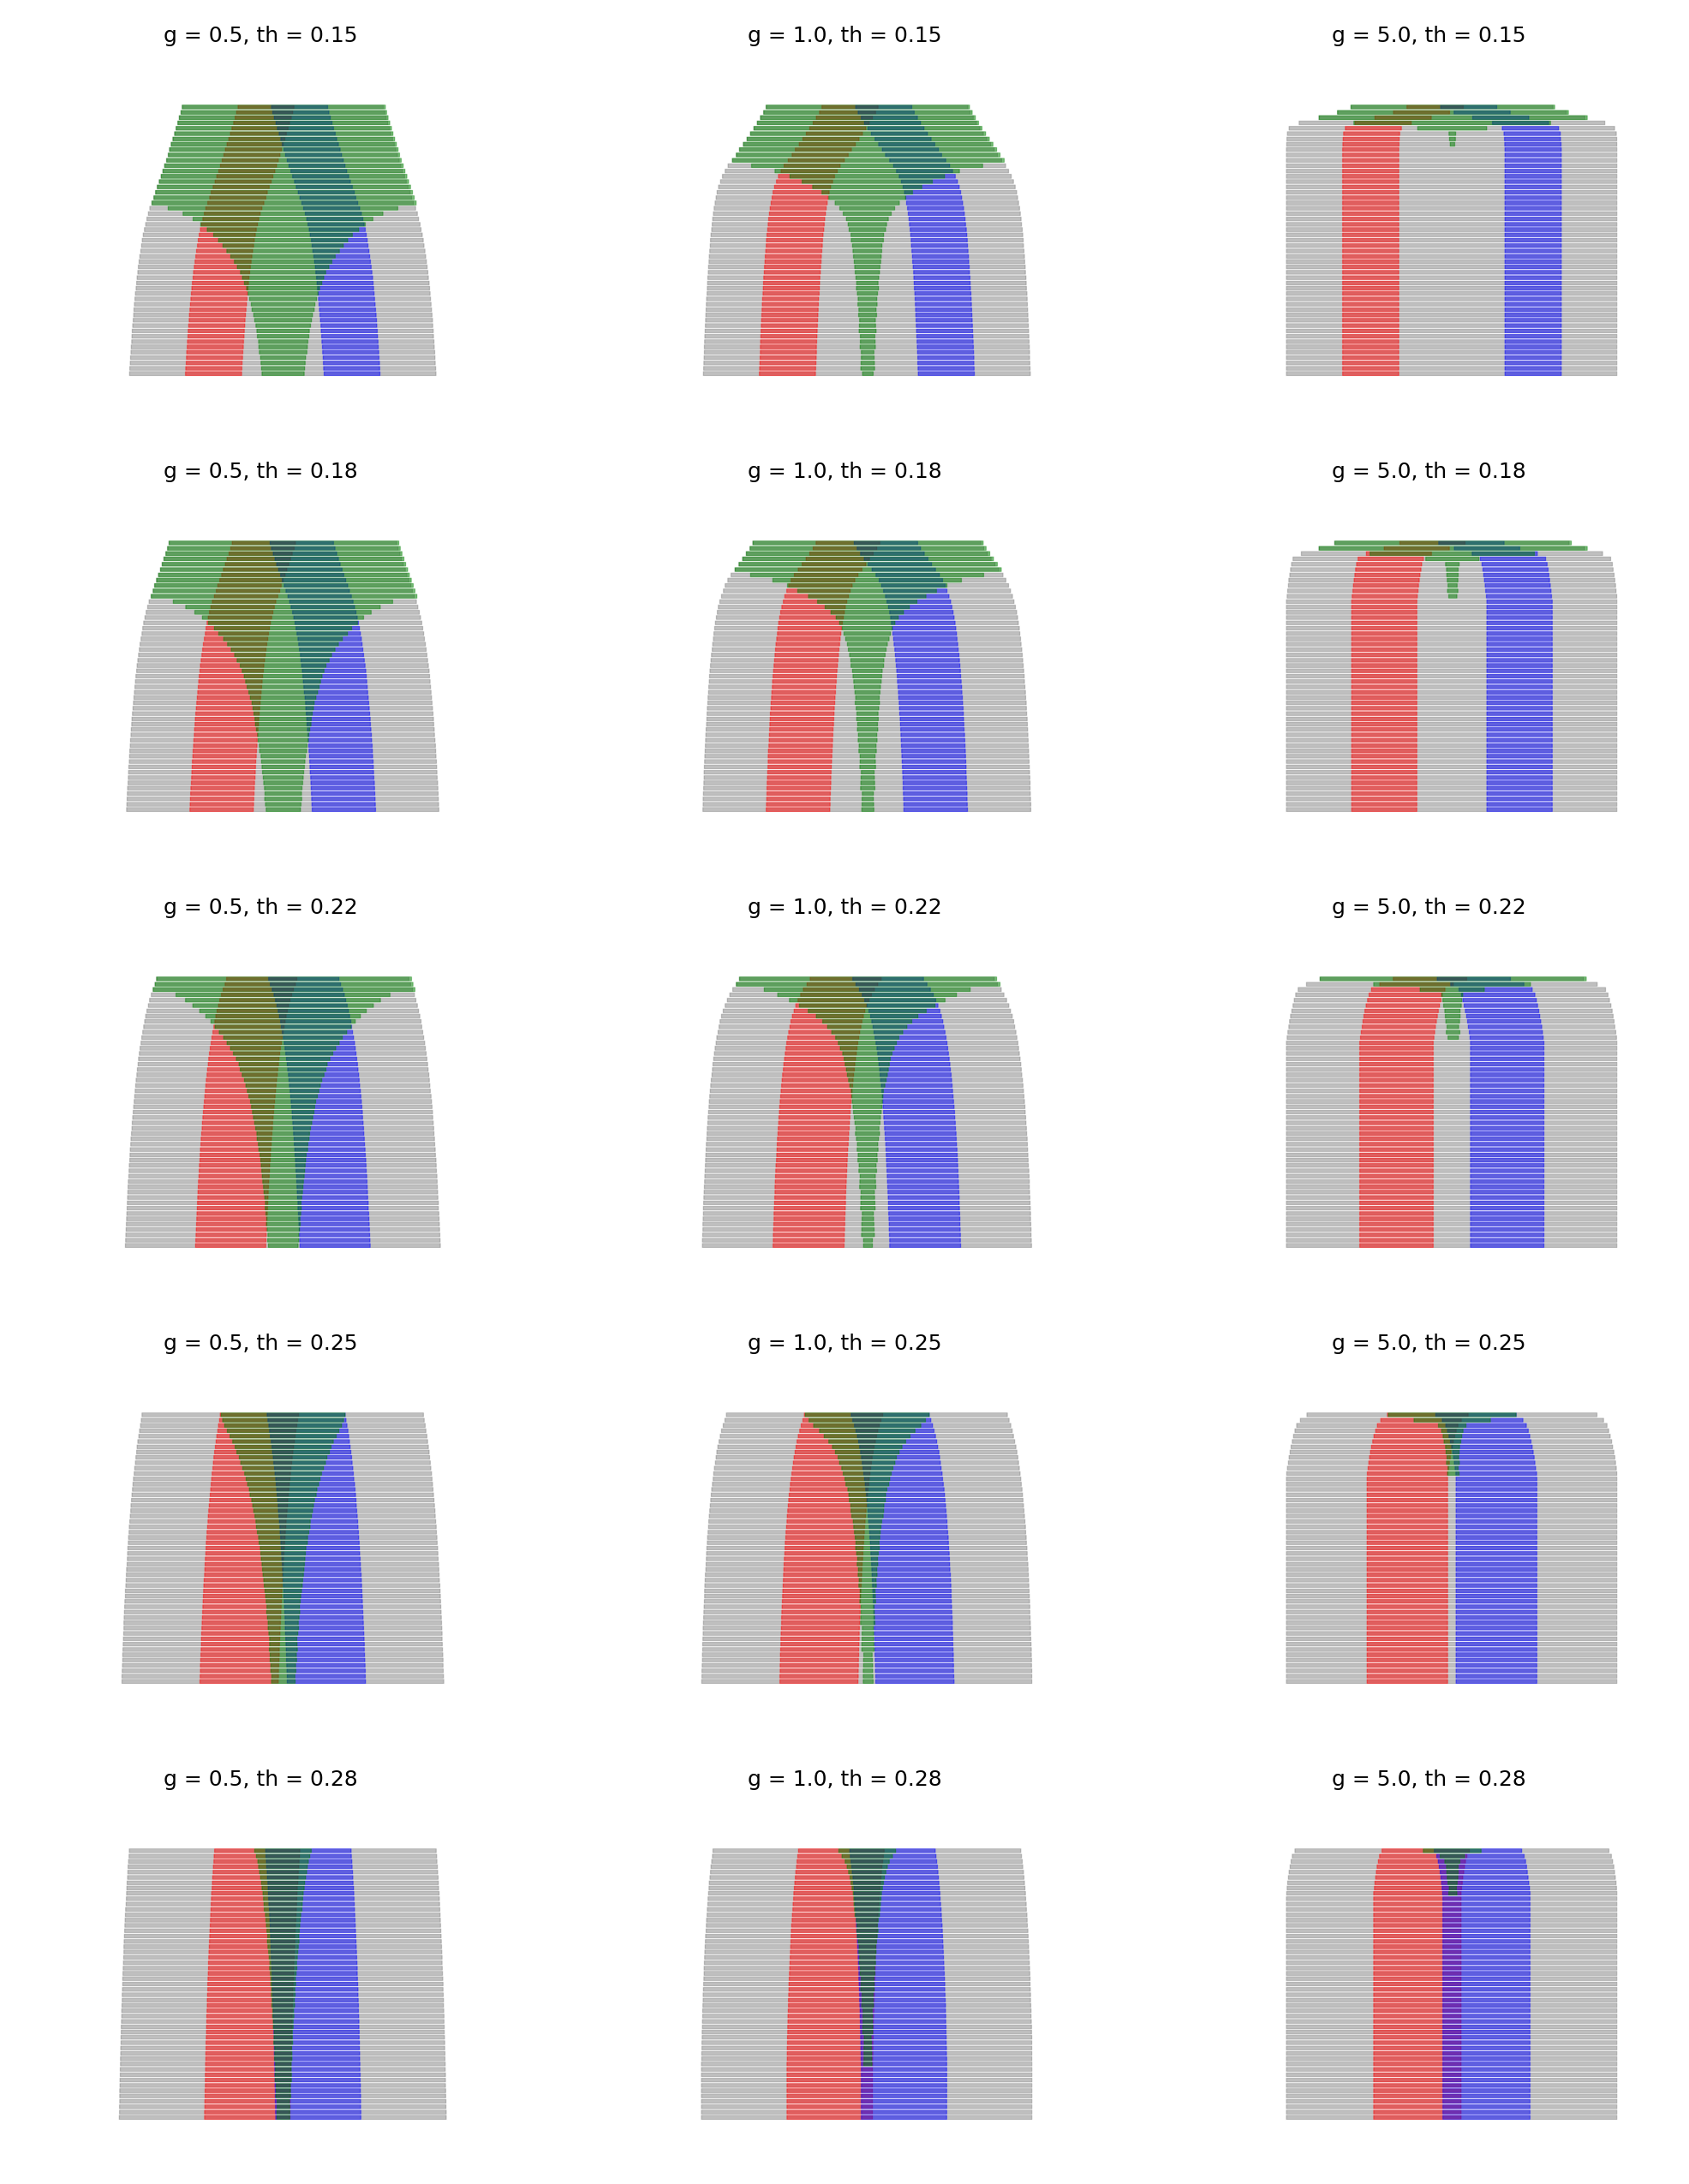

In [19]:
nrows, ncols = len(thresholds_to_test), len(g_to_test)
fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["large"][0], default_figsize["large"][1]))

# Iterate through the grid of subplots
for i, ng in enumerate(g_to_test):
    for j, nth in enumerate(thresholds_to_test):
        
        for nfolder in os.listdir( folder ):
            if ( str(ng) in nfolder) and ( str(nth) in nfolder):
                nfolder = os.path.join(folder, nfolder) + '/'
                
                grsizet    = np.load( nfolder + 'grsizet.npy')
                x_centerst = np.load( nfolder + 'x_centerst.npy')
                grt        = np.load( nfolder + 'grt.npy')
                Lt         = np.load( nfolder + 'Lt.npy')
    
        # Create a kymograph figure
        kymo_fig = plot_kymograph( )

        # Render kymo_fig to a canvas
        canvas = FigureCanvas(kymo_fig)
        canvas.draw()

        # Convert the figure to a numpy array
        kymo_array = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
        kymo_array = kymo_array.reshape(canvas.get_width_height()[::-1] + (4,))  # Include alpha channel

        # Display the kymograph as an image in the subplot
        ax[j, i].imshow(kymo_array)
        ax[j, i].axis('off')  # Turn off axes for aesthetics
        ax[j, i].set_title(f'g = {ng}, th = {np.round(nth, 2)}', fontsize=6)

        # Close the kymograph figure to free memory
        plt.close(kymo_fig)

# Show the combined figure
plt.tight_layout()
plt.show()

# Final parameters w/L, x0/L 

In [20]:
import pandas as pd

In [21]:
# Collect data in a list
results = []

# Loop through g and thresholds
for g in g_to_test:
    for threshold in thresholds_to_test:
        # Calculate parameters
        Lfinal = Lfinal_simulated[g][threshold]
        wr = w / Lfinal
        x0r = x0 / Lfinal

        # Append results to the list
        results.append({"Lfinal": Lfinal, "g": g, "threshold": threshold, "wr": wr, "x0r": x0r})

# Create a DataFrame from the results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["Lfinal", "g"])
results_df = results_df.reset_index(drop=True)

In [22]:
results_df

,Lfinal,g,threshold,wr,x0r
0,1.896462,5.0,0.28500,0.263649,0.263649
1,1.934679,1.0,0.28500,0.258441,0.258441
2,1.939801,0.5,0.28500,0.257758,0.257758
3,2.053419,5.0,0.25125,0.243496,0.243496
4,2.116105,0.5,0.25125,0.236283,0.236283
5,2.117953,1.0,0.25125,0.236077,0.236077
6,2.256318,5.0,0.21750,0.221600,0.221600
7,2.334765,1.0,0.21750,0.214154,0.214154
8,2.356746,0.5,0.21750,0.212157,0.212157
9,2.539500,5.0,0.18375,0.196889,0.196889


# Plotting picked variant for final figure

## Slow growth

In [23]:
g = g_to_test[0]

In [24]:
threshold_growth = thresholds_to_test[1]

In [25]:
threshold_growth

0.18375

In [26]:
for nfolder in os.listdir( folder ):
    if ( str(g) in nfolder) and ( str(threshold_growth) in nfolder):
        print(nfolder)
        nfolder = os.path.join(folder, nfolder) + '/'

        time_to_save = np.load( nfolder + 'time_to_save.npy')
        
        grsizet      = np.load( nfolder + 'grsizet.npy')
        grt          = np.load( nfolder + 'grt.npy')

        x_centerst   = np.load( nfolder + 'x_centerst.npy')
        x_gridt      = np.load( nfolder + 'x_gridt.npy')
        Lt           = np.load( nfolder + 'Lt.npy')

        st    = np.load( nfolder + 'st.npy')
        ft    = np.load( nfolder + 'ft.npy')
        
        s_steadyt    = np.load( nfolder + 's_steadyt.npy')
        f_steadyt    = np.load( nfolder + 'f_steadyt.npy')

        source_st    = np.load( nfolder + 'source_st.npy')
        source_ft    = np.load( nfolder + 'source_ft.npy')

th_0.18375_g_0.5


## Morphogen gradient profiles for three picked time points

- t0: the last moment then growth is in the whole system
- t1: the relative growth region is ~1/2 of the relative growth region at t0
- t2: growth has stopped

### Picking these time points

In [27]:
def plot_concentration(ax, n, i):
    ax.fill_between(x_centerst[n], source_st[n], color="red", alpha=0.5)
    ax.fill_between(x_centerst[n], source_ft[n], color="blue", alpha=0.5)
    ax.fill_between(x_centerst[n], threshold_growth * grt[n], color="green", alpha=0.5)
    ax.plot(x_centerst[n], st[n], 'r--', label='Source term (st)')
    ax.plot(x_centerst[n], ft[n], 'b--', label='Source term (ft)')
    ax.plot(x_centerst[n], s_steadyt[n], 'r', label='Steady state (st)')
    ax.plot(x_centerst[n], f_steadyt[n], 'b', label='Steady state (ft)')
    ax.set_title(f't = {round(time_to_save[n], 2)}')
    ax.set_xlabel('Position, x')
    ax.set_ylabel('Concentration, c(x)')
    ax.set_ylim(0, 0.4)

In [28]:
def find_closest_index(array, value):
    array = np.array(array)  # Ensure input is a numpy array
    # Mask NaN values
    valid_mask = ~np.isnan(array)
    valid_array = array[valid_mask]
    
    if valid_array.size == 0:
        raise ValueError("The array contains only NaN values.")
    
    # Find the index of the closest value in the valid array
    closest_index_in_valid = np.argmin(np.abs(valid_array - value))
    
    # Map back to the original array index
    original_index = np.where(valid_mask)[0][closest_index_in_valid]
    
    return int(original_index)

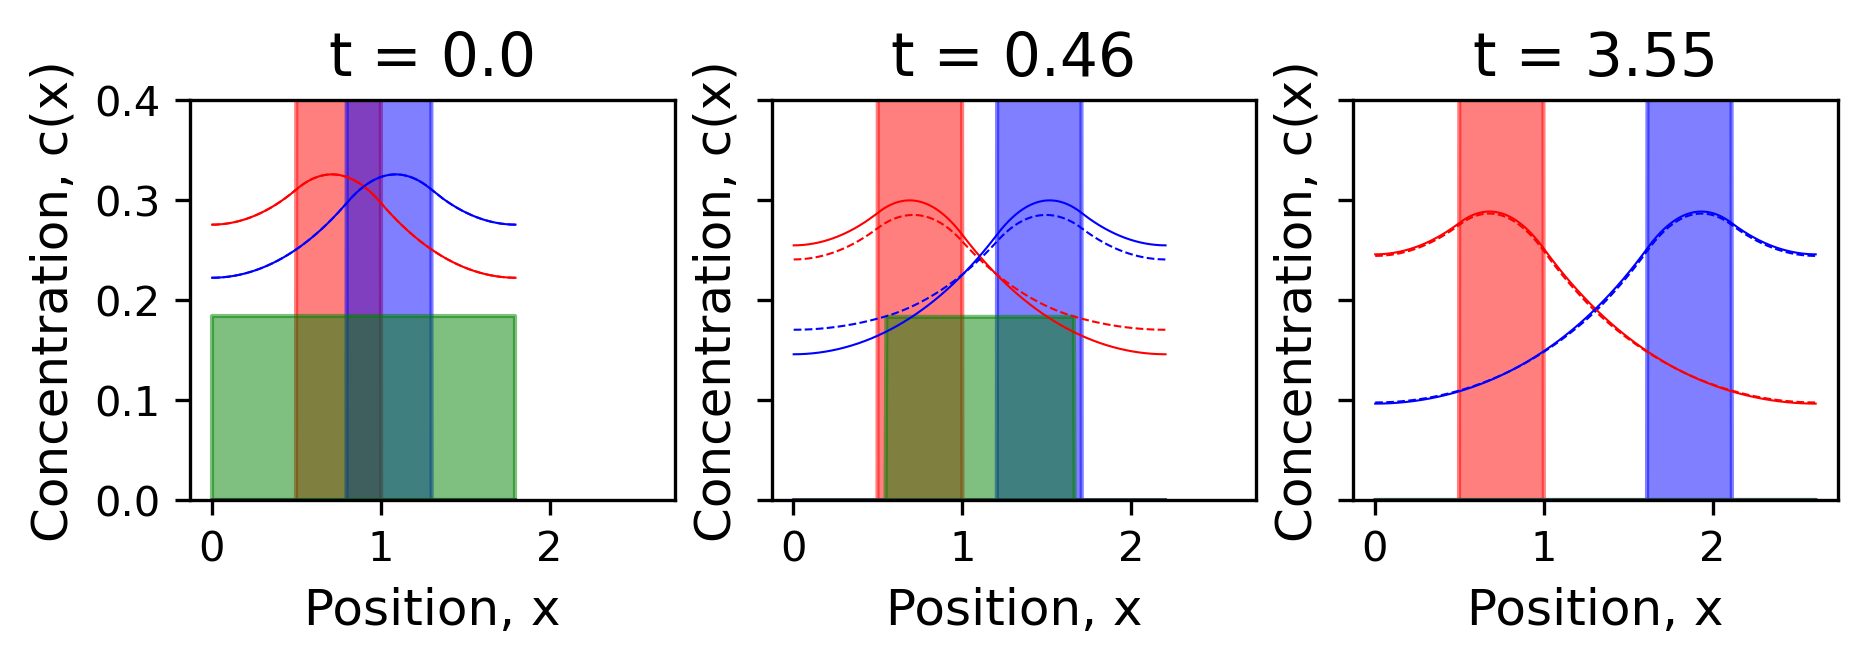

In [29]:
nrows, ncols = 1, 3
fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["large"][0], default_figsize["large"][1]/5), sharex=True, sharey=True)
t_to_plot = np.arange(0, 0.6*tmax+small_number, 0.6*tmax/nrows)

i = 1
ax = plt.subplot(nrows, ncols, i)
# t0: the last moment then growth is in the whole system
#if len( np.argwhere( np.round( grsizet / Lt, 1 ) == 1) ) == 0:
nt0 = 0
#else:
#nt0 = np.argwhere( np.round( grsizet / Lt, 1 ) == 1)[-1][0]
    
plot_concentration(ax, nt0, i)

i = 2
ax = plt.subplot(nrows, ncols, i)
# t1: the relative growth region is ~1/2 of the relative growth region at t0
nt1 = find_closest_index( (grsizet / Lt) / (grsizet / Lt)[nt0], 0.5 )
plot_concentration(ax, nt1, i)

i = 3
ax = plt.subplot(nrows, ncols, i)
# t2: growth has stopped
if len(np.argwhere( grsizet == 0 )) == 0:
    nt2 = len(grsizet)-1
else:
    nt2 = np.where( grsizet == 0 )[0][0]
    
plot_concentration(ax, nt2, i)

plt.savefig(f'fig/two_morph_profiles_t0_t1_t2_dynamics_g_{g}.pdf', bbox_inches='tight')

plt.show()

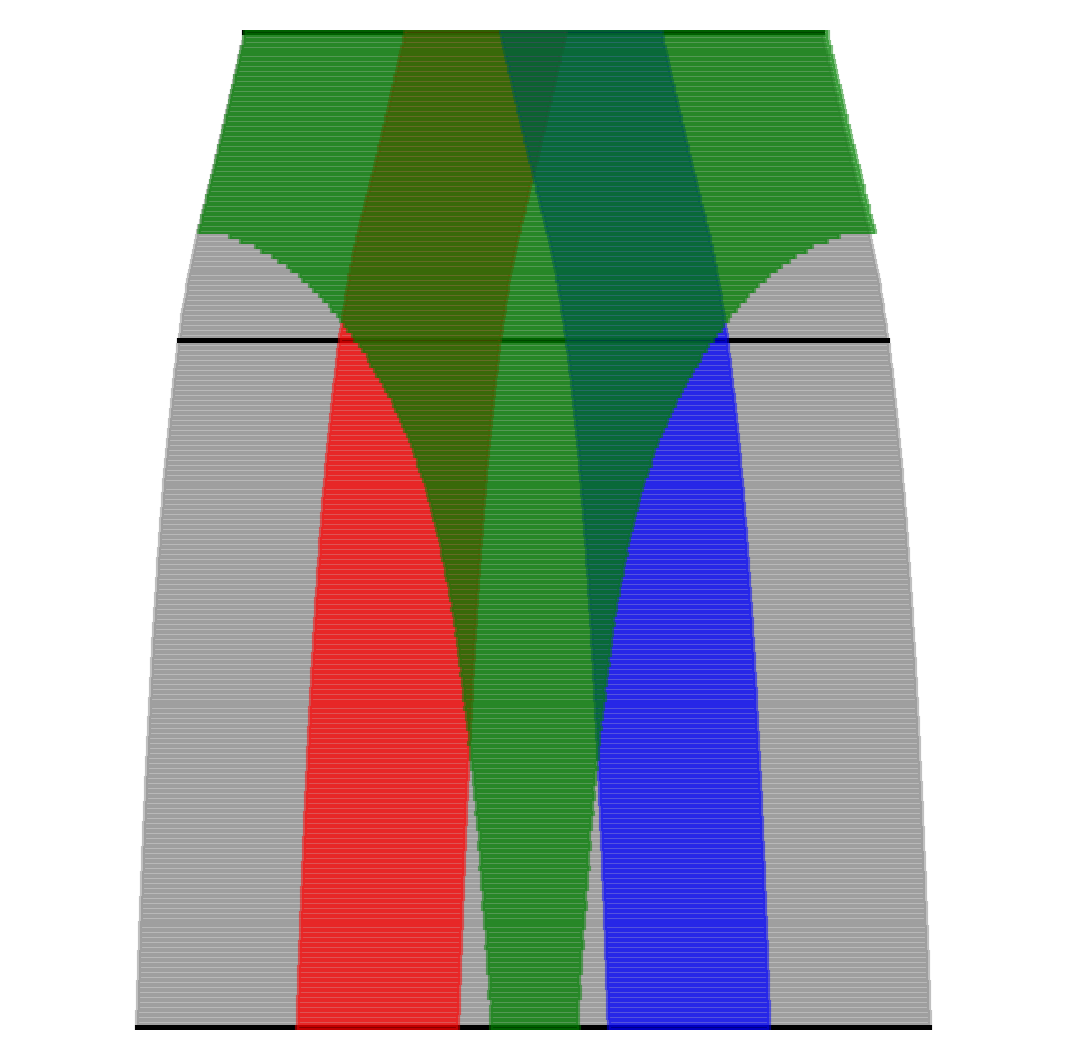

In [30]:
nrows, ncols = 201, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["medium"][0], default_figsize["medium"][0]), sharex=True, sharey=True, gridspec_kw={'hspace': 0})
#t_to_plot = np.arange(0, time_to_save[nt2+50] + small_number, time_to_save[nt2+50]/nrows)
t_to_plot = np.arange(0, 0.6*tmax+small_number, 0.6*tmax/nrows)

# characteristic time points
n_to_plot = []
for i in range(1, ncols*nrows+1):
    n = int(t_to_plot[i - 1] / dt / (ndt / ndt_to_save))
    n_to_plot.append( n )

nt = [ 
    n_to_plot[find_closest_index( n_to_plot, nt0 )], 
    n_to_plot[find_closest_index( n_to_plot, nt1 )], 
    n_to_plot[find_closest_index( n_to_plot, nt2 )] 
]

middle = 0
for i in range(1, ncols*nrows+1):
    ax = plt.subplot(nrows, ncols, i)
    n = int(t_to_plot[i - 1] / dt / (ndt / ndt_to_save))
    
    # shift to maintain the growth zone middle at the same position        
    if grsizet[n] != 0:
        x0gr = x_centerst[n][ np.nonzero( grt[n] )[0][0] ]  # Center position of the green rectangle
        x_start = middle - Lt[n]/2

    if n in nt:
        ax.add_patch(plt.Rectangle( (x_start, 0), Lt[n], 1, color='black' ))
    else:
        ax.add_patch(plt.Rectangle( (x_start, 0), Lt[n], 1, color='gray', alpha=0.5))
        
    ax.add_patch(plt.Rectangle( (x_start+x0, 0),         w,     1, color='red',  alpha=0.5))
    ax.add_patch(plt.Rectangle( (x_start+Lt[n]-w-x0, 0), w,     1, color='blue', alpha=0.5))

    if grsizet[n] != 0:
        x0gr = x_centerst[n][ np.nonzero( grt[n] )[0][0] ]
        ax.add_patch(plt.Rectangle((x_start + x0gr, 0), grsizet[n], 1, color='green', alpha=0.5))

    ax.set_xlim(-0.6*max(Lt), 0.6*max(Lt))
    ax.set_axis_off()
    
plt.savefig(f'fig/two_morph_kymograph_dynamics_g_{g}.pdf', bbox_inches='tight')

plt.show()

## Faster growth

In [31]:
g = g_to_test[2]

In [32]:
for nfolder in os.listdir( folder ):
    if ( str(g) in nfolder) and ( str(threshold_growth) in nfolder):
        print(nfolder)
        nfolder = os.path.join(folder, nfolder) + '/'

        time_to_save = np.load( nfolder + 'time_to_save.npy')
        
        grsizet      = np.load( nfolder + 'grsizet.npy')
        grt          = np.load( nfolder + 'grt.npy')

        x_centerst   = np.load( nfolder + 'x_centerst.npy')
        x_gridt      = np.load( nfolder + 'x_gridt.npy')
        Lt           = np.load( nfolder + 'Lt.npy')

        st    = np.load( nfolder + 'st.npy')
        ft    = np.load( nfolder + 'ft.npy')
        
        s_steadyt    = np.load( nfolder + 's_steadyt.npy')
        f_steadyt    = np.load( nfolder + 'f_steadyt.npy')

        source_st    = np.load( nfolder + 'source_st.npy')
        source_ft    = np.load( nfolder + 'source_ft.npy')

th_0.18375_g_5.0


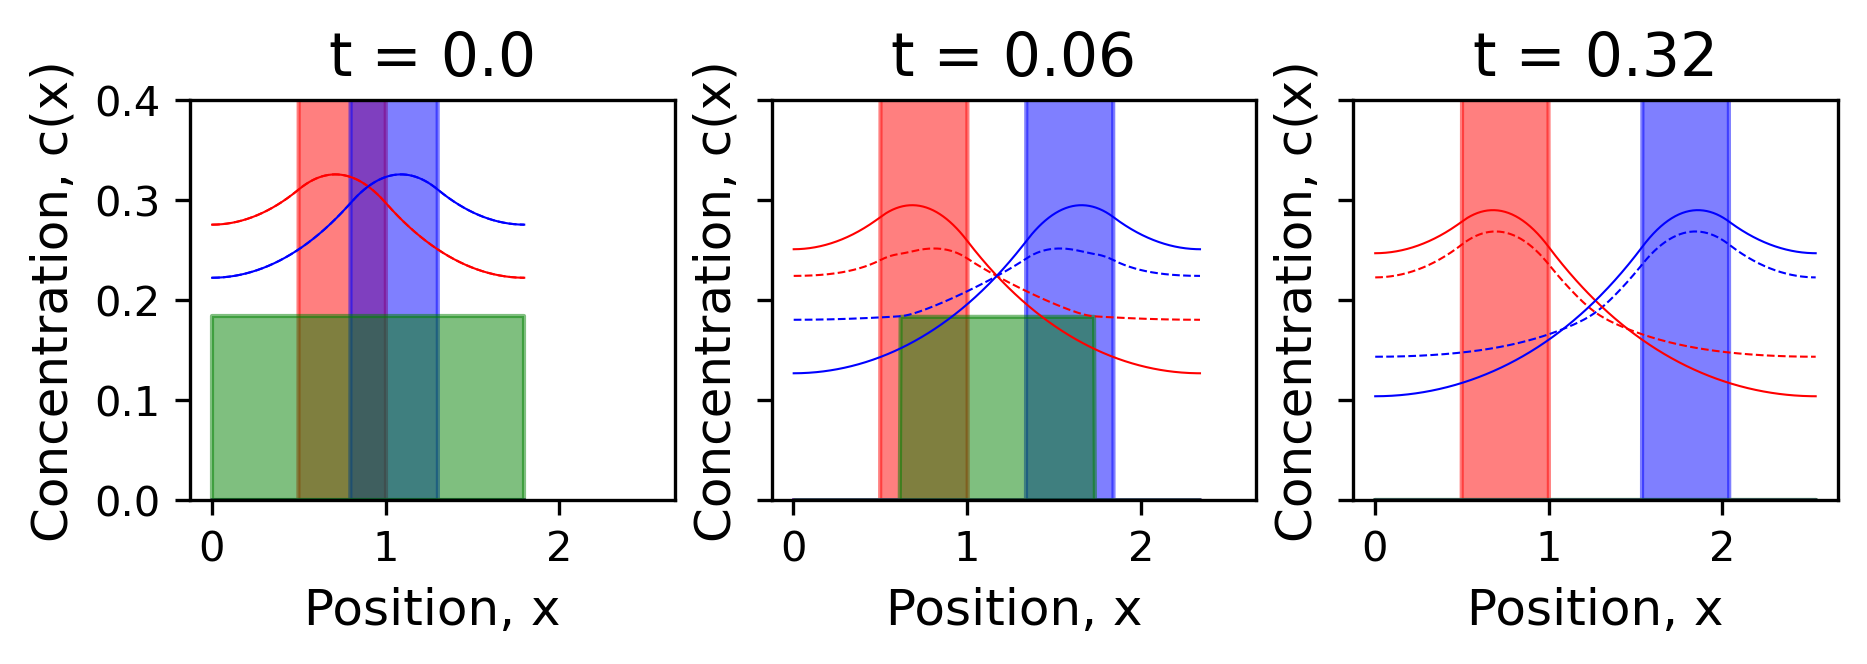

In [33]:
nrows, ncols = 1, 3
fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["large"][0], default_figsize["large"][1]/5), sharex=True, sharey=True)
t_to_plot = np.arange(0, 0.6*tmax+small_number, 0.6*tmax/nrows)

i = 1
ax = plt.subplot(nrows, ncols, i)
# t0: the last moment then growth is in the whole system
#if len( np.argwhere( np.round( grsizet / Lt, 1 ) == 1) ) == 0:
nt0 = 0
#else:
#nt0 = np.argwhere( np.round( grsizet / Lt, 1 ) == 1)[-1][0]
    
plot_concentration(ax, nt0, i)

i = 2
ax = plt.subplot(nrows, ncols, i)
# t1: the relative growth region is ~1/2 of the relative growth region at t0
nt1 = find_closest_index( (grsizet / Lt) / (grsizet / Lt)[nt0], 0.5 )
plot_concentration(ax, nt1, i)

i = 3
ax = plt.subplot(nrows, ncols, i)
# t2: growth has stopped
if len(np.argwhere( grsizet == 0 )) == 0:
    nt2 = len(grsizet)-1
else:
    nt2 = np.where( grsizet == 0 )[0][0]
    
plot_concentration(ax, nt2, i)

plt.savefig(f'fig/two_morph_profiles_t0_t1_t2_dynamics_g_{g}.pdf', bbox_inches='tight')

plt.show()

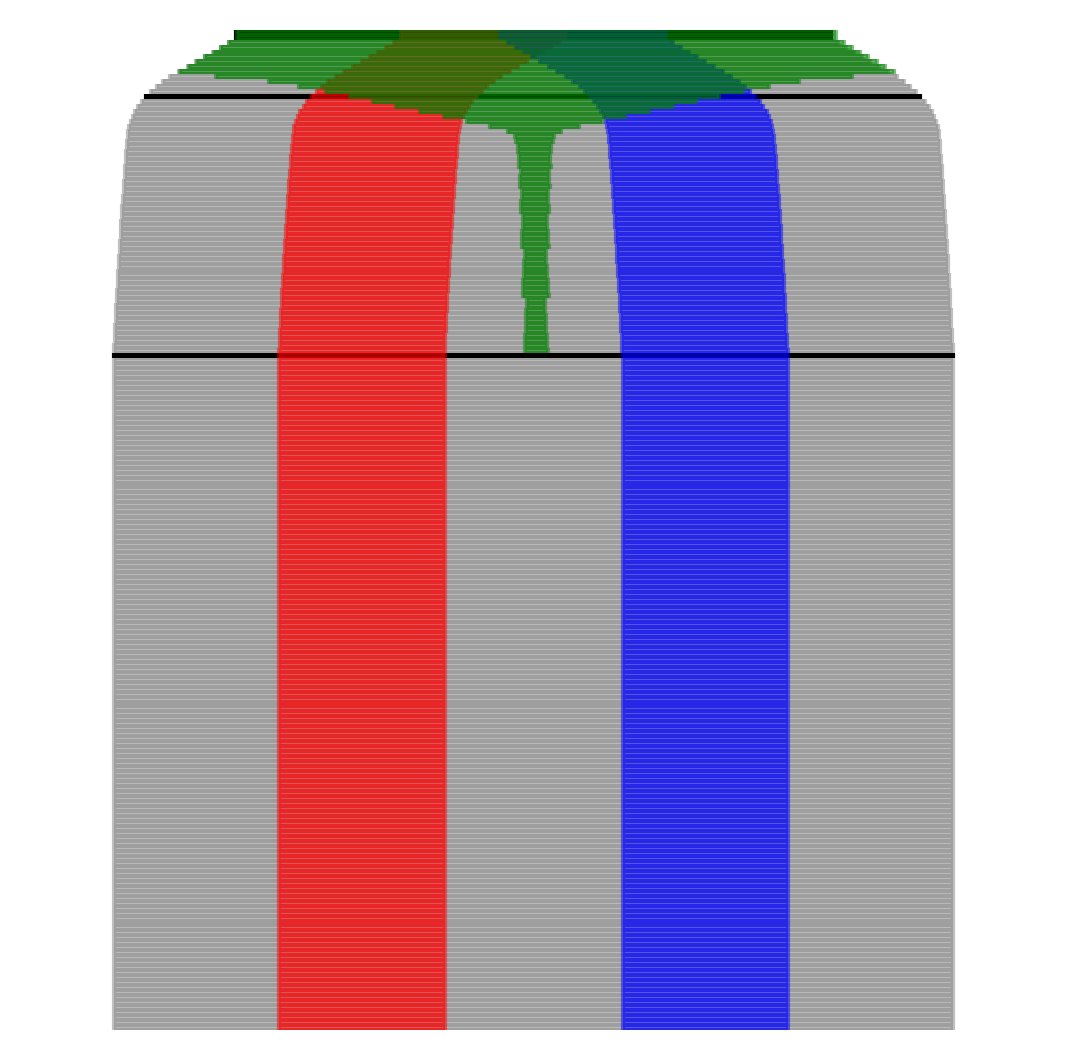

In [34]:
nrows, ncols = 201, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["medium"][0], default_figsize["medium"][0]), sharex=True, sharey=True, gridspec_kw={'hspace': 0})
#t_to_plot = np.arange(0, time_to_save[nt2+50] + small_number, time_to_save[nt2+50]/nrows)
t_to_plot = np.arange(0, tmax/5+small_number, tmax/5/nrows)

# characteristic time points
n_to_plot = []
for i in range(1, ncols*nrows+1):
    n = int(t_to_plot[i - 1] / dt / (ndt / ndt_to_save))
    n_to_plot.append( n )

nt = [ 
    n_to_plot[find_closest_index( n_to_plot, nt0 )], 
    n_to_plot[find_closest_index( n_to_plot, nt1 )], 
    n_to_plot[find_closest_index( n_to_plot, nt2 )] 
]

middle = 0
for i in range(1, ncols*nrows+1):
    ax = plt.subplot(nrows, ncols, i)
    n = int(t_to_plot[i - 1] / dt / (ndt / ndt_to_save))
    
    # shift to maintain the growth zone middle at the same position        
    if grsizet[n] != 0:
        x0gr = x_centerst[n][ np.nonzero( grt[n] )[0][0] ]  # Center position of the green rectangle
        x_start = middle - Lt[n]/2

    if n in nt:
        ax.add_patch(plt.Rectangle( (x_start, 0), Lt[n], 1, color='black' ))
    else:
        ax.add_patch(plt.Rectangle( (x_start, 0), Lt[n], 1, color='gray', alpha=0.5))
        
    ax.add_patch(plt.Rectangle( (x_start+x0, 0),         w,     1, color='red',  alpha=0.5))
    ax.add_patch(plt.Rectangle( (x_start+Lt[n]-w-x0, 0), w,     1, color='blue', alpha=0.5))

    if grsizet[n] != 0:
        x0gr = x_centerst[n][ np.nonzero( grt[n] )[0][0] ]
        ax.add_patch(plt.Rectangle((x_start + x0gr, 0), grsizet[n], 1, color='green', alpha=0.5))

    ax.set_xlim(-0.6*max(Lt), 0.6*max(Lt))
    ax.set_axis_off()
    
plt.savefig(f'fig/two_morph_kymograph_dynamics_g_{g}.pdf', bbox_inches='tight')

plt.show()